In [96]:
import pandas as pd
import numpy as np

Upload the labels.csv and processed_counts.csv files to colab or your local workspace.

This data associates a cell barcode, such as "AAAGCCTGGCTAAC-1", to a certain cell type label, such as "CD14+ Monocyte". For each cell barcode, there are also log RNA seq counts of 765 different genes, such as HES4.

label.csv stores the association between a cell barcode and a cell type label.

processed_counts.csv stores the normalized log read counts for each cell, where each row represents a single cell, and each column represents a gene.

In [97]:
labels_df = pd.read_csv("labels.csv")
counts_df = pd.read_csv("processed_counts.csv")

In [98]:
labels_df.head(2)

,index,bulk_labels
0,AAAGCCTGGCTAAC-1,CD14+ Monocyte
1,AAATTCGATGCACA-1,Dendritic


In [99]:
counts_df.head(2)

,Unnamed: 0,HES4,TNFRSF4,SSU72,PARK7,RBP7,SRM,MAD2L2,AGTRAP,TNFRSF1B,...,ATP5O,MRPS6,TTC3,U2AF1,CSTB,SUMO3,ITGB2,S100B,PRMT2,MT-ND3
0,AAAGCCTGGCTAAC-1,-0.326,-0.191,-0.728,-0.301,3.386,-0.531,2.016,3.377,4.841,...,-0.146,-0.532,-0.341,0.303,1.404,4.294,0.519,-0.21,-0.636,4.011
1,AAATTCGATGCACA-1,1.171,-0.191,0.795,-1.200,-0.174,-0.531,1.889,-0.486,-0.459,...,-1.136,-0.532,-0.341,-0.905,2.849,-0.585,1.172,-0.21,2.630,-0.490


Shuffle your data. Make sure your labels and the counts are shuffled together.

Split into train and test sets (80:20 split)

In [100]:
label_barcode_col_name = labels_df.columns[0]
label_value_col_name = labels_df.columns[1]
counts_barcode_col_name = counts_df.columns[0]
gene_column_names = counts_df.columns[1:]
merged_df = pd.merge(
    left=counts_df,
    right=labels_df[[label_barcode_col_name, label_value_col_name]],
    left_on=counts_barcode_col_name,
    right_on=label_barcode_col_name,
    how='inner'
)
print(f"merged_df shape after merge: {merged_df.shape}")

merged_df shape after merge: (700, 768)


In [101]:
from sklearn.model_selection import train_test_split
shuffled_df = merged_df.sample(frac=1, random_state=42).reset_index(drop=True)
X = shuffled_df[gene_column_names]
y = shuffled_df[label_value_col_name]
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2, 
    shuffle=False, 
    random_state=42 
)
print("--- Data Shapes After Splitting ---")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

--- Data Shapes After Splitting ---
X_train shape: (560, 765)
y_train shape: (560,)
X_test shape: (140, 765)
y_test shape: (140,)


Create a fully connected neural network for your autoencoder. Your latent space can be of any size less than or equal to 64. Too large may result in a poor visualization, and too small may result in high loss. 32 is a good starting point.

Consider using more than 1 hidden layer, and a sparcity constraint (l1 regularization).

Have an encoder model which is a model of only the layers for the encoding.

In [102]:
from tensorflow import keras
from keras import layers, regularizers
from keras.models import Model

In [103]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
input_dim = X_train.shape[1]
latent_dim = 32 
l1_factor = 1e-5
print(f"--- Autoencoder Configuration ---")
print(f"Input dimension (number of genes): {input_dim}")
print(f"Latent space dimension: {latent_dim}")
print(f"L1 regularization factor for latent layer activity: {l1_factor}\n")

--- Autoencoder Configuration ---
Input dimension (number of genes): 765
Latent space dimension: 32
L1 regularization factor for latent layer activity: 1e-05



In [104]:
encoder_input = keras.Input(shape=(input_dim,), name="encoder_input")
# Hidden layer 1
x_enc = layers.Dense(128, activation="relu", name="encoder_dense_1")(encoder_input)
# Hidden layer 2
x_enc = layers.Dense(64, activation="relu", name="encoder_dense_2")(x_enc)
# Using 'relu' for latent space activation
encoder_output = layers.Dense(latent_dim, activation="relu",
                              name="encoder_output_latent_space")(x_enc)

#standalone encoder model
encoder = Model(encoder_input, encoder_output, name="encoder")

encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 765)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_dense_1 (Dense)         │ (None, 128)            │        98,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_dense_2 (Dense)         │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_output_latent_space     │ (None, 32)             │         2,080 │
│ (Dense)                         │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 108,384 (423.38 KB)

 Trainable params: 108,384 (423.38 KB)

 Non-trainable params: 0 (0.00 B)

In [105]:
# maps the latent space representation back to the original input space
decoder_input_latent_space = keras.Input(shape=(latent_dim,), name="decoder_input_latent_space")
# Hidden layer 1 (mirrors encoder's second hidden layer)
x_dec = layers.Dense(64, activation="relu", name="decoder_dense_1")(decoder_input_latent_space)
# Hidden layer 2 (mirrors encoder's first hidden layer)
x_dec = layers.Dense(128, activation="relu", name="decoder_dense_2")(x_dec)
# Output layer: reconstructs the original input.
decoder_output_reconstruction = layers.Dense(input_dim, activation="sigmoid",
                                           name="decoder_output_reconstruction")(x_dec)

decoder = Model(decoder_input_latent_space, decoder_output_reconstruction, name="decoder")

print("--- Decoder Summary ---")
decoder.summary()

--- Decoder Summary ---


Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input_latent_space      │ (None, 32)             │             0 │
│ (InputLayer)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_dense_1 (Dense)         │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_dense_2 (Dense)         │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_output_reconstruction   │ (None, 765)            │        98,685 │
│ (Dense)                         │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 109,117 (426.24 KB)

 Trainable params: 109,117 (426.24 KB)

 Non-trainable params: 0 (0.00 B)

In [106]:
autoencoder_input = keras.Input(shape=(input_dim,), name="autoencoder_main_input")
encoded_representation = encoder(autoencoder_input)
reconstructed_output = decoder(encoded_representation)

autoencoder = Model(autoencoder_input, reconstructed_output, name="autoencoder")

In [107]:
autoencoder.compile(optimizer="adam", loss="mse")

print("--- Autoencoder Summary (Encoder + Decoder) ---")
autoencoder.summary()

--- Autoencoder Summary (Encoder + Decoder) ---


Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ autoencoder_main_input          │ (None, 765)            │             0 │
│ (InputLayer)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Functional)            │ (None, 32)             │       108,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 765)            │       109,117 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 217,501 (849.61 KB)

 Trainable params: 217,501 (849.61 KB)

 Non-trainable params: 0 (0.00 B)

Train your autoencoding using MSE loss.

Finally, identify the parameters which don't overfit, and use the same model architecture and train on all of the data together.

With a latent space size of 32, aim for 0.9 MSE loss on your test set, 0.95 with regularization. You will not be graded strictly on a loss cutoff.

In [108]:
print("--- Scaling Data ---")
scaler = MinMaxScaler()

# Convert to NumPy arrays
X_train_np = X_train.values if isinstance(X_train, pd.DataFrame) else X_train
X_test_np = X_test.values if isinstance(X_test, pd.DataFrame) else X_test

# Fit the scaler
X_train_scaled = scaler.fit_transform(X_train_np)
X_test_scaled = scaler.transform(X_test_np)

print(f"X_train_scaled shape: {X_train_scaled.shape}")
print(f"X_test_scaled shape: {X_test_scaled.shape}\n")

--- Scaling Data ---
X_train_scaled shape: (560, 765)
X_test_scaled shape: (140, 765)



Training Autoencoder (Initial Run with Validation)
Epoch 1/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1712 - val_loss: 0.0319
Epoch 2/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0303 - val_loss: 0.0328
Epoch 3/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0302 - val_loss: 0.0323
Epoch 4/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0296 - val_loss: 0.0319
Epoch 5/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0292 - val_loss: 0.0316
Epoch 6/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0288 - val_loss: 0.0314
Epoch 7/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0288 - val_loss: 0.0313
Epoch 8/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0287 - val_loss: 0.0310
Epoch 9/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0283 - val_loss: 0.0307
Epoch 10/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0281 - val_loss: 0.0304
Epoch 11/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0279 - val_loss: 0.0299
Epoch 12/20

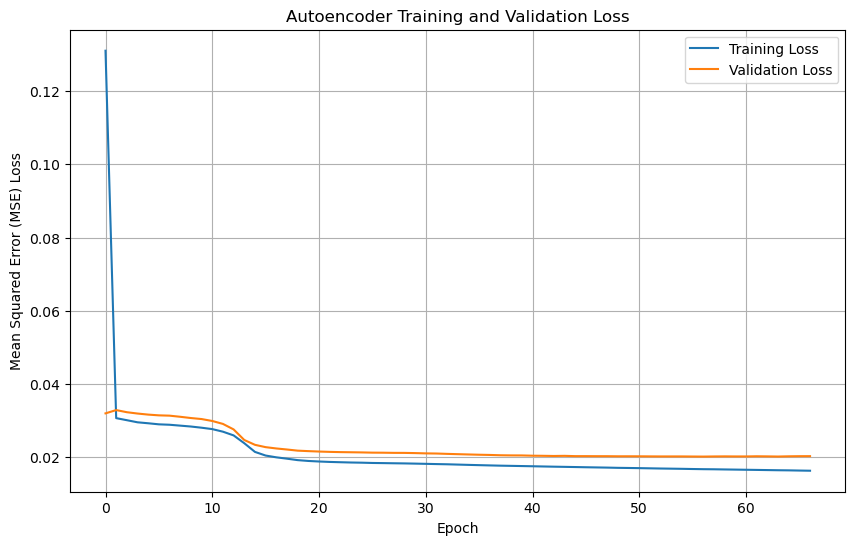

In [109]:
import tensorflow as tf
tf.config.optimizer.set_jit(False)
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
print("Training Autoencoder (Initial Run with Validation)")

# Define EarlyStopping callback:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

# Train
history = autoencoder.fit(
    X_train_scaled, X_train_scaled,
    epochs=200, 
    batch_size=32, 
    shuffle=True,
    validation_data=(X_test_scaled, X_test_scaled),
    callbacks=[early_stopping],
    verbose=1 
)

#Plot Training History
print("\n--- Plotting Training and Validation Loss ---")
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Autoencoder Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error (MSE) Loss')
plt.legend()
plt.grid(True)
plt.show()

In [110]:
test_loss = autoencoder.evaluate(X_test_scaled, X_test_scaled, verbose=0)
print(f"\n--- Initial Model Evaluation ---")
print(f"Test MSE Loss (from initial training with early stopping): {test_loss:.4f}")
optimal_epochs = np.argmin(history.history['val_loss']) + 1
print(f"Best validation loss was achieved at epoch: {optimal_epochs}")


--- Initial Model Evaluation ---
Test MSE Loss (from initial training with early stopping): 0.0201
Best validation loss was achieved at epoch: 57


In [111]:
def create_and_compile_autoencoder(input_dim_func, latent_dim_func, l1_factor_func):
    # Encoder
    encoder_input_val = keras.Input(shape=(input_dim_func,), name="encoder_input")
    x_enc_val = layers.Dense(128, activation="relu", name="encoder_dense_1")(encoder_input_val)
    x_enc_val = layers.Dense(64, activation="relu", name="encoder_dense_2")(x_enc_val)
    encoder_output_val = layers.Dense(latent_dim_func, activation="relu",
                                  activity_regularizer=regularizers.l1(l1_factor_func),
                                  name="final_encoder_output_latent_space")(x_enc_val)
    created_encoder = Model(encoder_input_val, encoder_output_val, name="final_encoder")

    # Decoder
    decoder_input_latent_space_val = keras.Input(shape=(latent_dim_func,), name="decoder_input_latent_space")
    x_dec_val = layers.Dense(64, activation="relu", name="decoder_dense_1")(decoder_input_latent_space_val)
    x_dec_val = layers.Dense(128, activation="relu", name="decoder_dense_2")(x_dec_val)
    decoder_output_reconstruction_val = layers.Dense(input_dim_func, activation="sigmoid",
                                               name="decoder_output_reconstruction")(x_dec_val)
    created_decoder = Model(decoder_input_latent_space_val, decoder_output_reconstruction_val, name="final_decoder")

    # Autoencoder
    autoencoder_main_input_val = keras.Input(shape=(input_dim_func,), name="autoencoder_main_input")
    encoded_representation_val = created_encoder(autoencoder_main_input_val)
    reconstructed_output_val = created_decoder(encoded_representation_val)
    created_autoencoder = Model(autoencoder_main_input_val, reconstructed_output_val, name="final_autoencoder")

    created_autoencoder.compile(optimizer="adam", loss="mse")
    return created_autoencoder, created_encoder

print("\n--- Preparing All Data for Final Training ---")
if isinstance(X_train, pd.DataFrame) and isinstance(X_test, pd.DataFrame):
    X_all_original = pd.concat([X_train, X_test], axis=0)
    X_all_np = X_all_original.values
elif isinstance(X_train, np.ndarray) and isinstance(X_test, np.ndarray):
    X_all_original = np.concatenate([X_train, X_test], axis=0)
    X_all_np = X_all_original
else:
    raise TypeError("X_train and X_test must be both Pandas DataFrames or NumPy arrays of the same type.")

print(f"Shape of combined original data X_all_original: {X_all_original.shape}")

scaler_final = MinMaxScaler()
X_all_scaled = scaler_final.fit_transform(X_all_np)
print(f"X_all_scaled shape: {X_all_scaled.shape}\n")


--- Preparing All Data for Final Training ---
Shape of combined original data X_all_original: (700, 765)
X_all_scaled shape: (700, 765)



In [112]:
print(f"--- Training Final Autoencoder on All Data for {optimal_epochs} Epochs ---")

# Create a new instance
final_autoencoder, final_encoder = create_and_compile_autoencoder(input_dim, latent_dim, l1_factor)

print("\nFinal Autoencoder Summary (Fresh Instance):")
final_autoencoder.summary()

history_final = final_autoencoder.fit(
    X_all_scaled, X_all_scaled,
    epochs=optimal_epochs,
    batch_size=32,
    shuffle=True,
    verbose=1
)

print("\n--- Final Autoencoder Training Complete ---")

--- Training Final Autoencoder on All Data for 57 Epochs ---

Final Autoencoder Summary (Fresh Instance):


Model: "final_autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ autoencoder_main_input          │ (None, 765)            │             0 │
│ (InputLayer)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ final_encoder (Functional)      │ (None, 32)             │       108,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ final_decoder (Functional)      │ (None, 765)            │       109,117 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 217,501 (849.61 KB)

 Trainable params: 217,501 (849.61 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/57
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1740  
Epoch 2/57
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0404
Epoch 3/57
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0314
Epoch 4/57
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0253
Epoch 5/57
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0238 
Epoch 6/57
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0228 
Epoch 7/57
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0219 
Epoch 8/57
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0210 
Epoch 9/57
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0205 
Epoch 10/57
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0205 
Epoch 11/57
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0203 
Epoch 12/57
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0203 
Epoch 13/57
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0201 
Epoch 14/57
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0199 
Epoch 15/57
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0203 
Epoch 

In [113]:
final_loss_on_all_data = final_autoencoder.evaluate(X_all_scaled, X_all_scaled, verbose=0)
print(f"MSE Loss of the final model on all data: {final_loss_on_all_data:.4f}")

MSE Loss of the final model on all data: 0.0171


In [ ]:
# # Save the Keras encoder model
# final_encoder.save("final_encoder.keras")
# print("Saved final_encoder to final_encoder.keras")
# # Save the scikit-learn scaler
# import joblib
# joblib.dump(scaler_final, "scaler_final.joblib")
# print("Saved scaler_final to scaler_final.joblib")

Saved final_encoder to final_encoder.keras
Saved scaler_final to scaler_final.joblib


Use PCA and t-SNE on the dataset.

Then use PCA on the latent space representation of the dataset.

Plot all of these.

In [115]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
if 'y_train' in globals() and 'y_test' in globals():
    if isinstance(y_train, pd.Series) and isinstance(y_test, pd.Series):
        y_all_labels = pd.concat([y_train, y_test], ignore_index=True)
    elif isinstance(y_train, np.ndarray) and isinstance(y_test, np.ndarray):
        y_all_labels = np.concatenate([y_train, y_test], axis=0)
    else:
        raise TypeError("y_train and y_test are not of compatible types (Pandas Series or NumPy array) or not defined.")
    
    # Verify shapes
    if X_all_scaled.shape[0] != len(y_all_labels):
        raise ValueError(f"Mismatch in number of samples between X_all_scaled ({X_all_scaled.shape[0]}) and y_all_labels ({len(y_all_labels)}). Check data alignment.")
    print(f"Successfully prepared y_all_labels with {len(y_all_labels)} entries.")
else:
    raise NameError("y_train and/or y_test not found. Cannot create y_all_labels. Please ensure they are defined from your initial data split.")

Successfully prepared y_all_labels with 700 entries.


In [ ]:
#PCA on Original Scaled Data (X_all_scaled)
print("\n--- Applying PCA to original scaled data ---")
pca_original = PCA(n_components=2, random_state=42)
X_pca_original = pca_original.fit_transform(X_all_scaled)
print(f"Shape of PCA (original data) output: {X_pca_original.shape}")

#t-SNE on Original Scaled Data (X_all_scaled)
print("\n--- Applying t-SNE to original scaled data (this may take some time) ---")
tsne_original = TSNE(n_components=2, random_state=42, perplexity=30,
                       n_iter=350, init='pca', learning_rate='auto') # Adjusted n_iter
X_tsne_original = tsne_original.fit_transform(X_all_scaled)
print(f"Shape of t-SNE (original data) output: {X_tsne_original.shape}")

# Get Autoencoder Latent Space Representation
print("\n--- Generating latent space representations from Autoencoder ---")
latent_space_data = final_encoder.predict(X_all_scaled)
print(f"Shape of Autoencoder latent space data: {latent_space_data.shape}")

#PCA on Autoencoder Latent Space Data
print("\n--- Applying PCA to Autoencoder latent space data ---")
pca_latent = PCA(n_components=2, random_state=42)
X_pca_latent = pca_latent.fit_transform(latent_space_data)
print(f"Shape of PCA (latent space) output: {X_pca_latent.shape}")


--- Applying PCA to original scaled data ---


Shape of PCA (original data) output: (700, 2)

--- Applying t-SNE to original scaled data (this may take some time) ---


/home/nathan/miniconda3/envs/bioe245_env/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Shape of t-SNE (original data) output: (700, 2)

--- Generating latent space representations from Autoencoder ---
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Shape of Autoencoder latent space data: (700, 32)

--- Applying PCA to Autoencoder latent space data ---
Shape of PCA (latent space) output: (700, 2)



--- Generating Plots ---


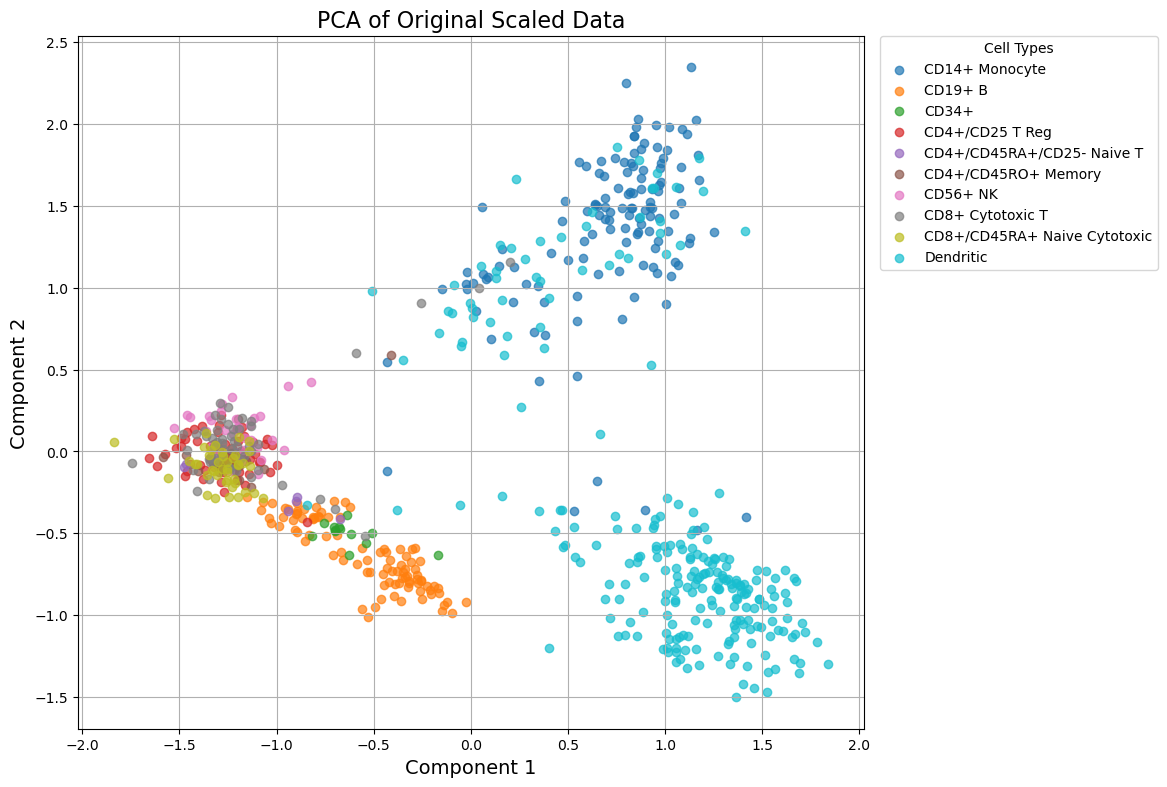

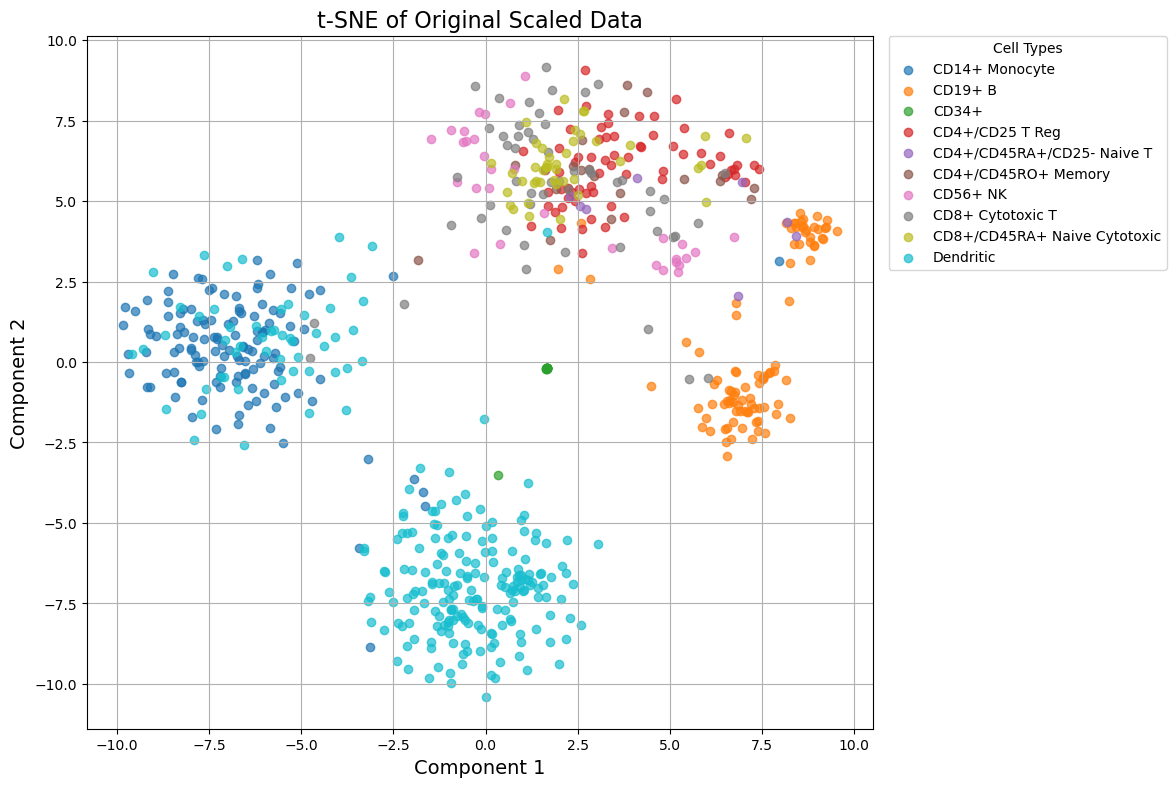

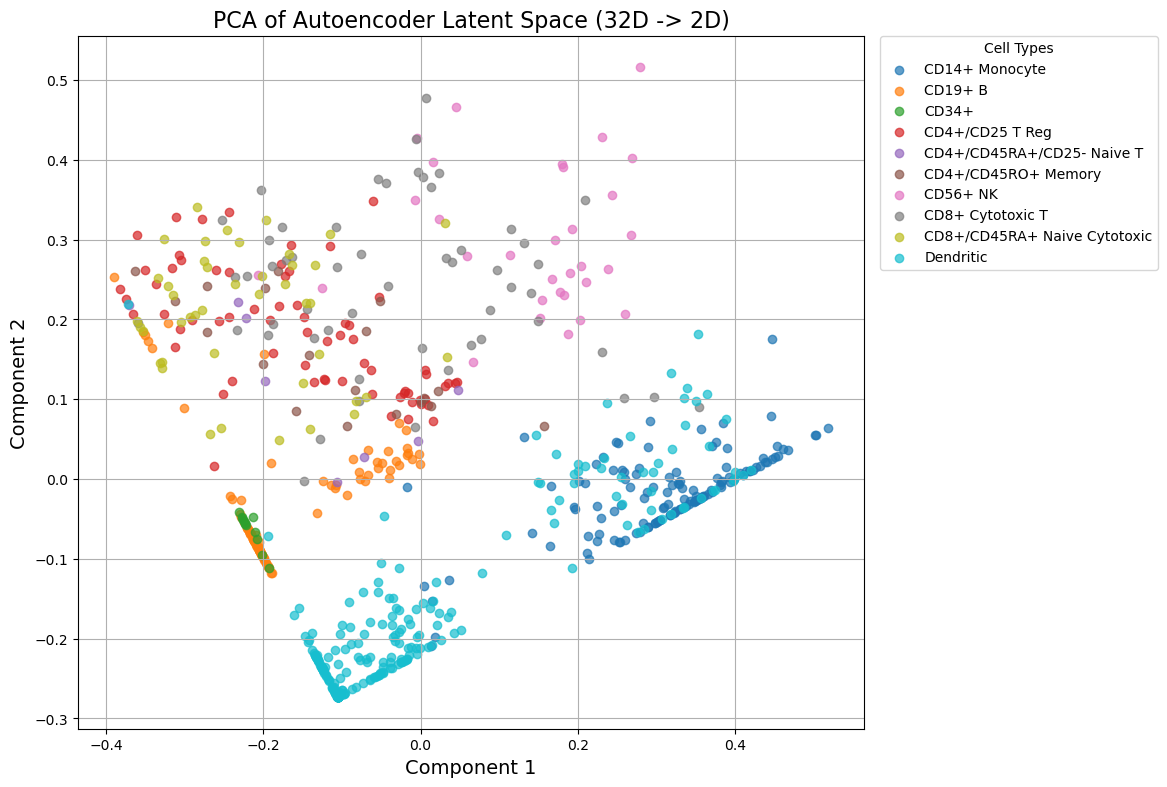

In [117]:
def plot_2d_representation(data_2d, labels_series, title_str):
    plt.figure(figsize=(12, 9))
    
    unique_cell_types = sorted(labels_series.unique())
    
    if len(unique_cell_types) <= 10:
        cmap = colormaps['tab10']
    elif len(unique_cell_types) <= 20:
        cmap = colormaps['tab20']
    else:
        cmap = colormaps['viridis'].resampled(len(unique_cell_types))

    is_listed_cmap = hasattr(cmap, 'colors')

    for i, cell_type in enumerate(unique_cell_types):
        idx = (labels_series == cell_type)
        # Ensure indices from boolean indexing
        current_data = data_2d[idx.values if isinstance(idx, pd.Series) else idx]
        
        if is_listed_cmap:
            color_val = cmap.colors[i % len(cmap.colors)]
        else: 
            color_val = cmap(i / (len(unique_cell_types) -1 )) if len(unique_cell_types) > 1 else cmap(0.5)
            
        plt.scatter(current_data[:, 0], current_data[:, 1],
                    color=color_val,
                    label=cell_type, alpha=0.7)
    
    plt.title(title_str, fontsize=16)
    plt.xlabel("Component 1", fontsize=14)
    plt.ylabel("Component 2", fontsize=14)
    plt.legend(title="Cell Types", bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)
    plt.grid(True)
    plt.subplots_adjust(right=0.78)
    plt.show()

# Convert y_all_labels to a pandas Series
if isinstance(y_all_labels, np.ndarray):
    y_all_labels_series = pd.Series(y_all_labels)
else:
    y_all_labels_series = y_all_labels 

print("\n--- Generating Plots ---")
plot_2d_representation(X_pca_original, y_all_labels_series, "PCA of Original Scaled Data")
plot_2d_representation(X_tsne_original, y_all_labels_series, "t-SNE of Original Scaled Data")
plot_2d_representation(X_pca_latent, y_all_labels_series, "PCA of Autoencoder Latent Space (32D -> 2D)")


Compare the results of PCA, t-SNE, and your autoencoder as ways to visualize the data.

Comparing the three dimensionality reduction approaches—PCA on the original data, t-SNE on the original data, and PCA on the autoencoder's 32D latent space—the t-SNE visualization provided the clearest separation of the annotated PBMC cell types. While PCA on the original data showed significant overlap, particularly among T-cell subtypes, t-SNE successfully grouped most cell types into visually distinct clusters, highlighting its strength in capturing local similarities in high-dimensional gene expression data. 

The autoencoder approach, followed by PCA, offered an improvement over the initial PCA by creating more defined clusters for certain cell types like Dendritic cells and B cells, suggesting it learned a useful non-linear representation. However, it did not achieve the overall distinctness and tight clustering across all cell types that t-SNE provided, making t-SNE the most effective method for this particular visualization task.